# Manipulate 2011 LSOA boundary data from EW to London

Part of [london-data](https://github.com/jamesdamillington/london-data), by [jamesdamillington](https://github.com/jamesdamillington)

## Aim
Produce a `.csv` containing geometries that can later be joined to other data for analysis. This file will be used by students regularly so should be a relatively small file on disk.

In [1]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2022-08-24


In [2]:
import pyproj
import geopandas as gpd
import shapely
import pandas as pd
import matplotlib.pyplot as plt

Get a lookup table for unique Borough (LAD) names and to join MSOA and LAD info to LSOA geometries. 

[Original data](https://geoportal.statistics.gov.uk/datasets/ons::output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-december-2011-lookup-in-england-and-wales/about) downloaded [2022-08-24] from ONS and saved as *OA_to_LSOA_to_MSOA_to_LAD_(December_2011)_Lookup_EW.csv*. 

> Source: Office for National Statistics licensed under the Open Government Licence v.3.0  
Contains OS data © Crown copyright and database right (2022)

In [3]:
lookup = pd.read_csv("../data/inputs/geographies/census/OA_to_LSOA_to_MSOA_to_LAD_(December_2011)_Lookup_EW.csv")
lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181408 entries, 0 to 181407
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   OA11CD    181408 non-null  object
 1   LSOA11CD  181408 non-null  object
 2   LSOA11NM  181408 non-null  object
 3   MSOA11CD  181408 non-null  object
 4   MSOA11NM  181408 non-null  object
 5   LAD11CD   181408 non-null  object
 6   LAD11NM   181408 non-null  object
 7   LAD11NMW  10036 non-null   object
 8   ObjectId  181408 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 12.5+ MB


/tmp/ipykernel_54250/2940574849.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  lookup = pd.read_csv("../data/inputs/geographies/census/OA_to_LSOA_to_MSOA_to_LAD_(December_2011)_Lookup_EW.csv")


In [4]:
lookup.drop('LAD11NMW', axis=1, inplace=True)   #drop welsh names (not needed for London)
lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181408 entries, 0 to 181407
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   OA11CD    181408 non-null  object
 1   LSOA11CD  181408 non-null  object
 2   LSOA11NM  181408 non-null  object
 3   MSOA11CD  181408 non-null  object
 4   MSOA11NM  181408 non-null  object
 5   LAD11CD   181408 non-null  object
 6   LAD11NM   181408 non-null  object
 7   ObjectId  181408 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 11.1+ MB


In [5]:
lads = pd.unique(lookup.LAD11NM)
lads

array(['City of London', 'Barking and Dagenham', 'Barnet', 'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge',
       'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Westminster', 'Bolton', 'Bury',
       'Manchester', 'Oldham', 'Rochdale', 'Salford', 'Stockport',
       'Tameside', 'Trafford', 'Wigan', 'Knowsley', 'Liverpool',
       'St. Helens', 'Sefton', 'Wirral', 'Barnsley', 'Doncaster',
       'Rotherham', 'Sheffield', 'Gateshead', 'Newcastle upon Tyne',
       'North Tyneside', 'South Tyneside', 'Sunderland', 'Birmingham',
       'Coventry', 'Dudley', 'Sandwell', 'Solihull', 'Walsall',
       'Wolverhampton', 'Bradford', 'Calderdale', 'Kirklees'

In [6]:
lads = list(lads)
london_lads = lads[:lads.index('Westminster')+1]
london_lads

['City of London',
 'Barking and Dagenham',
 'Barnet',
 'Bexley',
 'Brent',
 'Bromley',
 'Camden',
 'Croydon',
 'Ealing',
 'Enfield',
 'Greenwich',
 'Hackney',
 'Hammersmith and Fulham',
 'Haringey',
 'Harrow',
 'Havering',
 'Hillingdon',
 'Hounslow',
 'Islington',
 'Kensington and Chelsea',
 'Kingston upon Thames',
 'Lambeth',
 'Lewisham',
 'Merton',
 'Newham',
 'Redbridge',
 'Richmond upon Thames',
 'Southwark',
 'Sutton',
 'Tower Hamlets',
 'Waltham Forest',
 'Wandsworth',
 'Westminster']

[LSOA geometries](https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-areas-december-2011-boundaries-full-clipped-bfc-ew-v3/about) data downloaded [2022-08-24] as *Lower_Layer_Super_Output_Areas_(December_2011)_Boundaries_Full_Clipped_(BFC)_EW_V3.zip*

> Source: Office for National Statistics licensed under the Open Government Licence v.3.0  
Contains OS data © Crown copyright and database right (2022)

In [7]:
boundaries = gpd.read_file("../data/inputs/geographies/census/Lower_Layer_Super_Output_Areas_(December_2011)_Boundaries_Full_Clipped_(BFC)_EW_V3/Lower_Layer_Super_Output_Areas_(December_2011)_Boundaries_Full_Clipped_(BFC)_EW_V3.shp")

<AxesSubplot:>

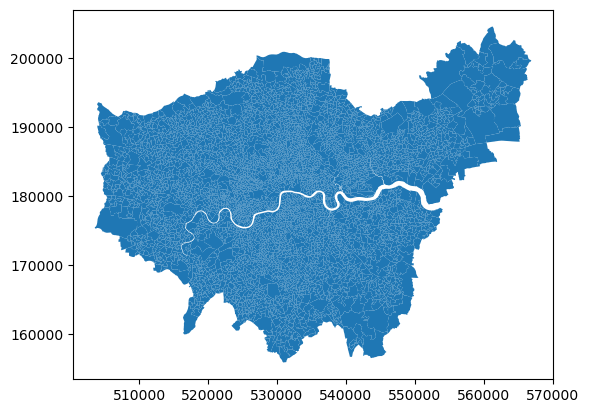

In [8]:
london = boundaries[boundaries['LSOA11NM'].str.contains("|".join(london_lads))]   #from https://stackoverflow.com/a/71399966
london = london.copy(deep=False)
london.plot()

Filtering on 'Brent' in LAD names brings in Brentwood LSOAs. Remove these areas:

In [9]:
london = london[~london['LSOA11NM'].str.contains('Brentwood')]

<AxesSubplot:>

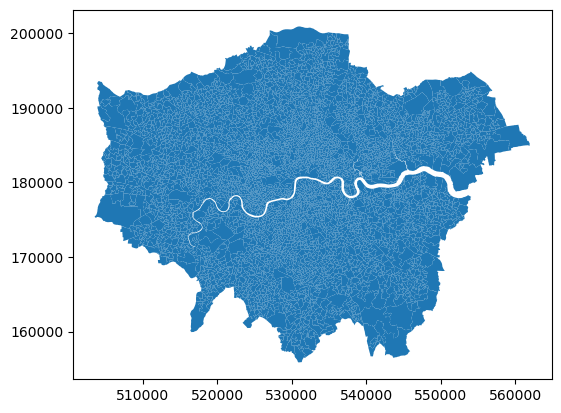

In [10]:
london.plot()

In [11]:
lookup.drop(['OA11CD', 'ObjectId'], axis=1, inplace=True)
lookup.drop_duplicates(subset=['LSOA11NM'], inplace=True)
lookup.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
4,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London
8,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London
16,E01032739,City of London 001F,E02000001,City of London 001,E09000001,City of London
17,E01032740,City of London 001G,E02000001,City of London 001,E09000001,City of London


## Join MSOA and LAD info

In [12]:
merge_london = pd.merge(london, lookup, how='left', on='LSOA11CD')
merge_london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    4835 non-null   int64   
 1   LSOA11CD    4835 non-null   object  
 2   LSOA11NM_x  4835 non-null   object  
 3   BNG_E       4835 non-null   int64   
 4   BNG_N       4835 non-null   int64   
 5   LONG_       4835 non-null   float64 
 6   LAT         4835 non-null   float64 
 7   Shape_Leng  4835 non-null   float64 
 8   Shape__Are  4835 non-null   float64 
 9   Shape__Len  4835 non-null   float64 
 10  geometry    4835 non-null   geometry
 11  LSOA11NM_y  4835 non-null   object  
 12  MSOA11CD    4835 non-null   object  
 13  MSOA11NM    4835 non-null   object  
 14  LAD11CD     4835 non-null   object  
 15  LAD11NM     4835 non-null   object  
dtypes: float64(5), geometry(1), int64(3), object(7)
memory usage: 642.1+ KB


In [13]:
merge_london = merge_london[['LSOA11CD', 'LSOA11NM_x', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'geometry']]
merge_london.rename(columns = {'LSOA11NM_x':'LSOA11NM'}, inplace = True)
merge_london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  4835 non-null   object  
 1   LSOA11NM  4835 non-null   object  
 2   MSOA11CD  4835 non-null   object  
 3   MSOA11NM  4835 non-null   object  
 4   LAD11CD   4835 non-null   object  
 5   LAD11NM   4835 non-null   object  
 6   geometry  4835 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 302.2+ KB


In [14]:
merge_london.to_file("../data/geographies/census/london2011-lsoa.shp")

/home/james/anaconda3/envs/london-data/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [15]:
#merge_london.to_csv("../data/geographies/census/london2011-lsoa.csv")  #not written as large file size

## Simplify geometries
Data files written to file are quite large (~40MB for .shp and ~65MB for .csv). Use GeoPandas.simplify to reduce file size.

First check CRS of the file to understand units for tolerance parameter. 

In [16]:
merge_london.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [17]:
merge_london_simple = merge_london.copy(deep=False)
merge_london_simple.geometry = merge_london.simplify(tolerance=10)
merge_london_simple.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532151.537 181867.433, 532308.875 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532634.497 181926.016, 532618.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532153.703 182165.155, 532158.250 18..."
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,"POLYGON ((533619.062 181402.364, 533765.806 18..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,"POLYGON ((545126.852 184310.838, 545296.239 18..."


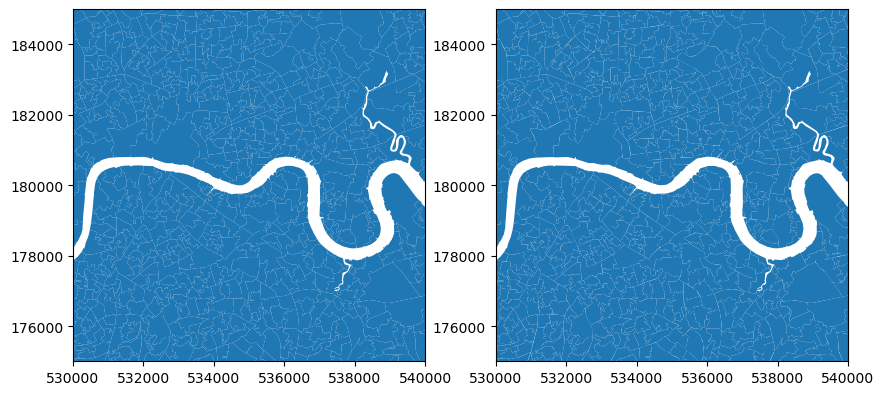

In [18]:
custom_xlim=(530000,540000)
custom_ylim=(175000,185000)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
merge_london.plot(ax=ax[0])
merge_london_simple.plot(ax=ax[1])
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

Simplifying with `tolerance=10` seems to have limitied impact on visualisation at intermediate scales.

We can see some impact at fine scales

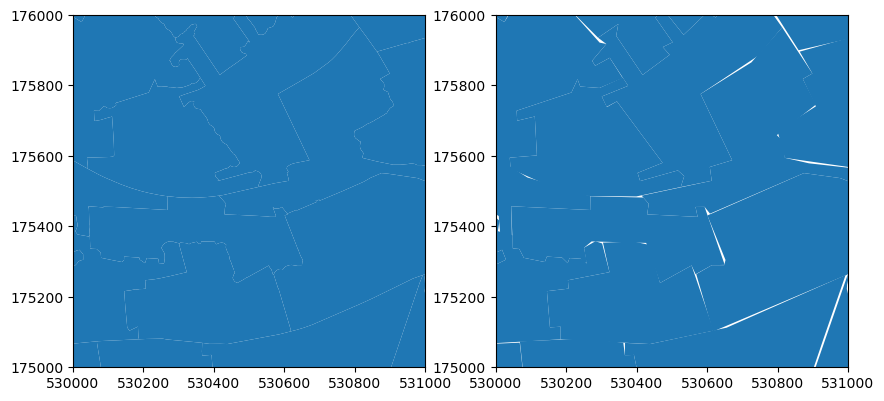

In [19]:
custom_xlim=(530000,531000)
custom_ylim=(175000,176000)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
merge_london.plot(ax=ax[0])
merge_london_simple.plot(ax=ax[1])
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

But at Borough level, visualisation is fine. We'll use this tolerance (if students want to use the original we can make that available as .shp).

<AxesSubplot:>

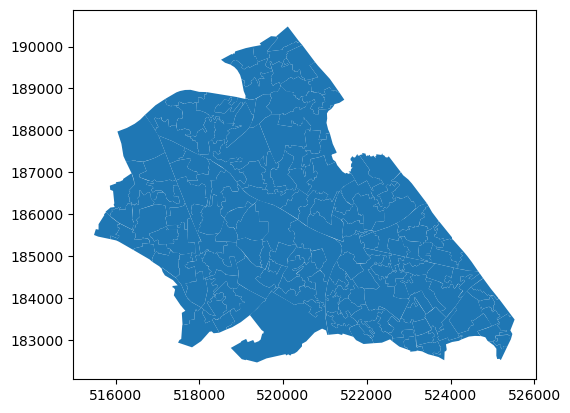

In [20]:
merge_london_simple[merge_london_simple['LSOA11NM'].str.contains('Brent')].plot()

In [21]:
#write to file
merge_london_simple.to_csv("../data/geographies/census/london2011-lsoa_simple.csv")

Given units for EPSG:27000 (BNG) are metres we also don't need multiple decimal places. We can remove as follows

In [22]:
# first step from https://gis.stackexchange.com/a/336382
merge_london_trunc = merge_london_simple.copy(deep=False)
merge_london_trunc.geometry = merge_london_simple.geometry.apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x,rounding_precision=0)))
merge_london_trunc.geometry = merge_london_trunc.geometry.apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x,trim=True)))

This also seems to have limited impact on visualisation (but will further reduce csv file size):

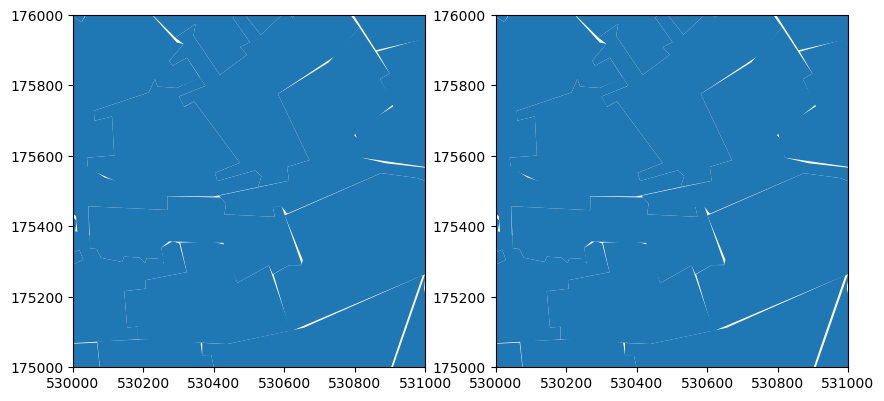

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
merge_london_simple.plot(ax=ax[0])
merge_london_trunc.plot(ax=ax[1])
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

<AxesSubplot:>

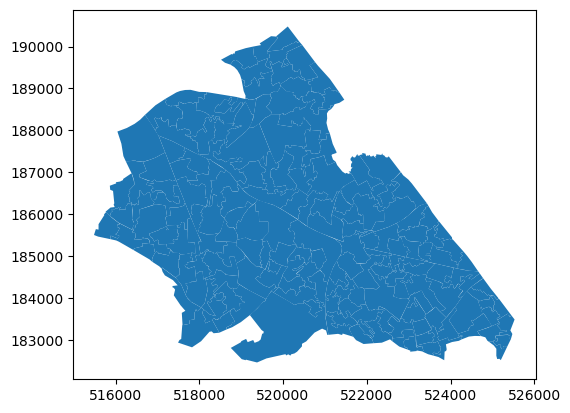

In [24]:
merge_london_trunc[merge_london_trunc['LSOA11NM'].str.contains('Brent')].plot()

So now we can write to file:

In [25]:
merge_london_trunc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  4835 non-null   object  
 1   LSOA11NM  4835 non-null   object  
 2   MSOA11CD  4835 non-null   object  
 3   MSOA11NM  4835 non-null   object  
 4   LAD11CD   4835 non-null   object  
 5   LAD11NM   4835 non-null   object  
 6   geometry  4835 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 302.2+ KB


In [26]:
merge_london_trunc.to_csv("../data/geographies/census/london2011-lsoa_trunc.csv", index=False)

## Final checks

Read back in to check:

In [27]:
#https://gist.github.com/jamesdamillington/5f7c4c231b74a068be4cb232b1b9dea5
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads

file_path = "../data/geographies/census/london2011-lsoa_trunc.csv"
geom_col = 'geometry'
epsg_id = 27700
crs_str = "EPSG:" + str(epsg_id) 

df = pd.read_csv(file_path)
gdf = gpd.GeoDataFrame(df)  #geopandas
gdf[geom_col] = gdf[geom_col].apply(lambda x: loads(x))  #from shapely
gdf = gdf.set_geometry(geom_col).set_crs(crs_str)

In [28]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  4835 non-null   object  
 1   LSOA11NM  4835 non-null   object  
 2   MSOA11CD  4835 non-null   object  
 3   MSOA11NM  4835 non-null   object  
 4   LAD11CD   4835 non-null   object  
 5   LAD11NM   4835 non-null   object  
 6   geometry  4835 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 264.5+ KB


<AxesSubplot:>

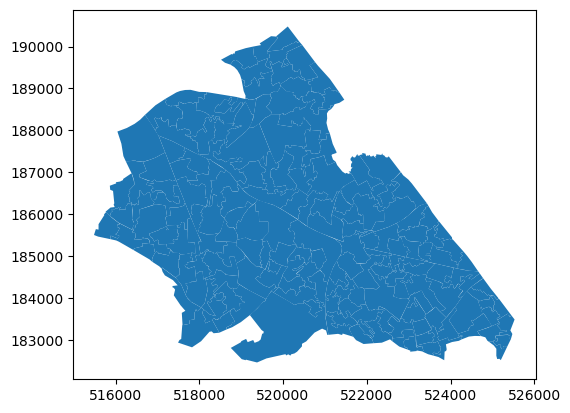

In [29]:
gdf[gdf['LSOA11NM'].str.contains('Brent')].plot()